<a href="https://colab.research.google.com/github/valentinwerner1/UniversityProjects/blob/main/TWSM/Homework/VW_5_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Libraries

In [97]:
from google.colab import drive
drive.mount('/content/drive')
#TWSM_path = "/content/drive/MyDrive/teaching/TWSM/"

#from TWSM import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Dropout, BatchNormalization
from keras.models import Sequential, load_model 
import tensorflow as tf
import spacy
import numpy as np
## Import packages
import pickle
import pandas as pd
from gensim.models import Word2Vec
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score
from scipy.spatial.distance import cosine
# run this from a normal command line
#!python -m spacy download en_core_web_md #160MB


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install whatlies

https://stackoverflow.com/questions/56927602/unable-to-load-the-spacy-model-en-core-web-lg-on-google-colab

Now, *** restart the colab runtime *** !!

## Data

**IMD Movie Reviews**

In [ ]:
from tensorflow.keras.datasets import imdb
(train_data, train_labels), (test_data, test_labels) = imdb.load_data(
    num_words=10000)
full_docs = np.concatenate((train_data, test_data))

17473536/17464789 [==============================] - 0s 0us/step


In [ ]:
#turn all ints to words
word_index = imdb.get_word_index()
reverse_word_index = dict(
    [(value, key) for (key, value) in word_index.items()])
dec_reviews = ["" for x in range(full_docs.shape[0])]
for j in range(full_docs.shape[0]):
    dec_reviews[j] = " ".join(
    [reverse_word_index.get(i - 3, "?") for i in full_docs[j]])

1654784/1641221 [==============================] - 0s 0us/step


In [ ]:
#resplit
train = dec_reviews[:25000]
test = dec_reviews[25000:]
len(train), len(test)

(25000, 25000)

In [ ]:
#Task1
#corpus
corpus_gen=[doc.split() for doc in train]
corpus_test = [doc.split() for doc in test]
#Word2Vec
model = Word2Vec(corpus_gen, size = 100, min_count = 566)

In [ ]:
#Task2
corpus_new = [[model.wv[word.strip()] for word in doc if word in model.wv.vocab.keys()] for doc in corpus_gen]
train = [np.mean(doc, axis = 0) for doc in corpus_new if len(doc) != 0]

corpus_new_2 = [[model.wv[word.strip()] for word in doc if word in model.wv.vocab.keys()] for doc in corpus_test]
test = [np.mean(doc, axis = 0) for doc in corpus_new_2 if len(doc) != 0]

In [ ]:
train = np.array(train)
test = np.array(test)

In [ ]:
train.shape, test.shape, train_labels.shape, test_labels.shape

((25000, 100), (25000, 100), (25000,), (25000,))

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(train, y_train, test_size=0.30, random_state=1, stratify = y_train)

In [ ]:
def plot(y_test, NN_preds, fit):
    """return the final confusion matrix, loss plot and accuracy,
    plotting for binary targets"""
    max_acc = max(fit.history["val_binary_accuracy"])
    max_acc_index = fit.history["val_binary_accuracy"].index(max_acc)
    print(f"best validation accuracy was found at {max_acc} on epoch {max_acc_index}")
    print(f"test accuracy of the model is {accuracy_score(y_test, NN_preds)}")

    fig, ax = plt.subplots(1, 3, figsize = (30,8))
    cm = confusion_matrix(y_test, NN_preds, labels=[0,1])
    cm_matrix = pd.DataFrame(data=cm, columns=["Predicted: 0",'Predicted: 1'], index=['Actual:0','Actual:1'])
    sns.heatmap(cm_matrix, annot=True, fmt='d', cmap='YlGnBu', ax = ax[0])
    plt.title("Classification for test data")

    loss = fit.history["loss"]
    test_loss = fit.history["val_loss"]
    epochs = range(1, len(loss)+1)
    sns.lineplot(x = epochs, y = loss, color = "b", label = "Training loss", ax = ax[1])
    sns.lineplot(x = epochs, y = test_loss, color = "g", label = "Validation loss", ax = ax[1])
    plt.title("Loss over epochs")

    train_acc = fit.history["binary_accuracy"]
    test_acc = fit.history["val_binary_accuracy"]
    sns.lineplot(x = epochs, y =train_acc, color = "b", label = "Training accuracy", ax = ax[2])
    sns.lineplot(x = epochs, y = test_acc, color = "g", label = "Validation accuracy", ax = ax[2])
    ax[2].axhline(max_acc, color = "r", label = f"Maximum Validation Accuracy = {round(max_acc,3)}")
    plt.legend()
    plt.title("Accuracy over epochs")

In [ ]:
#Task3
model = Sequential()
model.add(Dense(40, input_shape = (len(train[0]),), activation = "relu"))
model.add(Dense(40, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

opt = tf.keras.optimizers.Adam(lr = 0.0001)
model.compile(loss = "BinaryCrossentropy", optimizer = opt, metrics = ["BinaryAccuracy"])
early_stop = EarlyStopping(patience = 25, monitor = "val_binary_accuracy", restore_best_weights = True)

fit = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 300, verbose = 1, batch_size = 64, callbacks = [early_stop])

Epoch 1/300


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


274/274 [==============================] - 2s 4ms/step - loss: 0.6750 - binary_accuracy: 0.5969 - val_loss: 0.6615 - val_binary_accuracy: 0.6196
Epoch 2/300
274/274 [==============================] - 1s 2ms/step - loss: 0.6355 - binary_accuracy: 0.6554 - val_loss: 0.6060 - val_binary_accuracy: 0.6967
Epoch 3/300
274/274 [==============================] - 1s 2ms/step - loss: 0.5628 - binary_accuracy: 0.7404 - val_loss: 0.5182 - val_binary_accuracy: 0.7628
Epoch 4/300
274/274 [==============================] - 1s 2ms/step - loss: 0.4858 - binary_accuracy: 0.7845 - val_loss: 0.4555 - val_binary_accuracy: 0.7996
Epoch 5/300
274/274 [==============================] - 1s 2ms/step - loss: 0.4431 - binary_accuracy: 0.8020 - val_loss: 0.4273 - val_binary_accuracy: 0.8091
Epoch 6/300
274/274 [==============================] - 1s 2ms/step - loss: 0.4234 - binary_accuracy: 0.8103 - val_loss: 0.4137 - val_binary_accuracy: 0.8176
Epoch 7/300
274/274 [==============================] - 1s 2ms/step - l

best validation accuracy was found at 0.8249333500862122 on epoch 21
test accuracy of the model is 0.82672


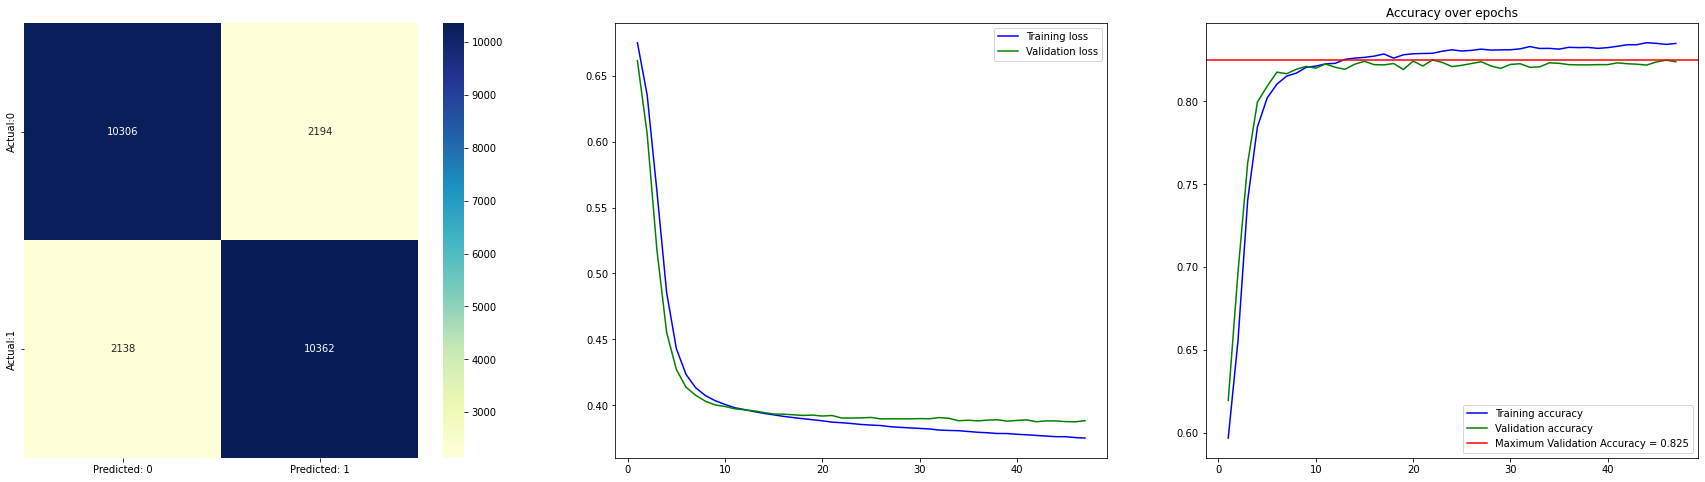

In [ ]:
NN_preds = model.predict(test).round()
plot(test_labels, NN_preds, fit)
#the model predicts negative just as well as positive; its very balanced

In [ ]:
#Task4
bing = pd.read_csv("/content/drive/MyDrive/bing.csv").drop(columns = ["Unnamed: 0"])
bing.head()

,word,sentiment
0,2-faces,negative
1,abnormal,negative
2,abolish,negative
3,abominable,negative
4,abominably,negative


In [70]:
corpus_pos = np.array(bing_pos).reshape(len(bing[bing.sentiment == "positive"].word),1)
corpus_neg = np.array(bing_neg).reshape(len(bing[bing.sentiment == "negative"].word),1)

In [79]:
# Train the model for embeddings of size 100 with min_count=1 (because there is only 1 "sentence")
model_pos = Word2Vec(corpus_pos, size=100, min_count=1)
model_neg = Word2Vec(corpus_neg, size=100, min_count=1)

In [115]:
# Average word2vec corpus for positive sentiment 
#Code from Philipp
corpus_w2v_pos=[[model_pos.wv[word] for word in doc if word in model_pos.wv.vocab.keys()] for doc in corpus_gen]
positive=[i for i in range(len(corpus_gen)) if len(corpus_w2v_pos[i])>0]

corpus_w2v2_pos=[corpus_w2v_pos[i] for i in positive]
dec_rev_pos =[dec_reviews[i] for i in positive]

# Document average representation
corpus_w2v_avg_pos = [np.mean(doc, axis = 0) for doc in corpus_w2v2_pos]

In [116]:
# Average word2vec corpus for negative sentiment 
#Code from Philipp
corpus_w2v_neg=[[model_neg.wv[word] for word in doc if word in model_neg.wv.vocab.keys()] for doc in corpus_gen]
positive=[i for i in range(len(corpus_gen)) if len(corpus_w2v_neg[i])>0]

corpus_w2v2_neg=[corpus_w2v_neg[i] for i in positive]
dec_rev_neg =[dec_reviews[i] for i in positive]

# Document average representation
corpus_w2v_avg_neg = [np.mean(doc, axis = 0) for doc in corpus_w2v2_neg]

In [123]:
#task5 (positive review)
#Code from Philipp
print("Most similar word to avg. embedding:", model_neg.wv.similar_by_vector(corpus_w2v_avg_clean_neg[0], topn=1))
print("Max cosine similarity to negative embedding:", np.round(model_neg.wv.cosine_similarities(corpus_w2v_avg_clean_neg[0], model_neg.wv.vectors).max(),2))
print("Avg. cosine similarity to negative embedding:", np.round(model_neg.wv.cosine_similarities(corpus_w2v_avg_clean_neg[0], model_neg.wv.vectors).mean(),2))
print("Avg. cosine similarity to negative embedding top 10:", np.round(np.sort(model_neg.wv.cosine_similarities(corpus_w2v_avg_clean_neg[0], model_neg.wv.vectors))[::-1][:25].mean(),2))

Most similar word to avg. embedding: [('cry', 0.7189089059829712)]
Max cosine similarity to negative embedding: 0.72
Avg. cosine similarity to negative embedding: 0.0
Avg. cosine similarity to negative embedding top 10: 0.33


In [124]:
print("Most similar word to avg. embedding:", model_pos.wv.similar_by_vector(corpus_w2v_avg_clean_pos[0], topn=1))
print("Max cosine similarity to positive embedding:", np.round(model_pos.wv.cosine_similarities(corpus_w2v_avg_clean_pos[0], model_pos.wv.vectors).max(),2))
print("Avg. cosine similarity to positive embedding:", np.round(model_pos.wv.cosine_similarities(corpus_w2v_avg_clean_pos[0], model_pos.wv.vectors).mean(),2))
print("Avg. cosine similarity to positive embedding top 25:", np.round(np.sort(model_pos.wv.cosine_similarities(corpus_w2v_avg_clean_pos[0], model_pos.wv.vectors))[::-1][:25].mean(),2))

Most similar word to avg. embedding: [('amazing', 0.6390657424926758)]
Max cosine similarity to positive embedding: 0.64
Avg. cosine similarity to positive embedding: 0.0
Avg. cosine similarity to positive embedding top 25: 0.31


Seems like the review (although its labeled as positive) is pretty neutral. This may be due to the fact that words like "cry" are not necessarily negative in the movie context.

In [122]:
dec_reviews[0]

"? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ? is an amazing actor and now the same being director ? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ? to the two little boy's that played the ? of norman and paul they were just brilliant children are often left out of the ? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done don't you th

#### Tasks

1. Train a word2vec model of dimension $100$ on the IMD data. (considering words appearing in more than 50 documents) Save the model if you like.

2. Compute the embedding for each review (average word2vec)

3. Fit a keras classifier to the embedded reviews. (2 hidden layers of size 40 each) Report/Monitor the accuracy on the test data.

4. Load the bing sentiment dictionary. Compute two separate embeddings for the negative and positive sentiments.

5. Compute the similarity between these two vectors and a few selected reviews. Does it agree with their label?


-------------------------------------------
## Solution